In [47]:
import glob
import numpy
import pandas
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import multiprocessing as mp
import os
from build import build_model
import coralme
plt.rcParams['svg.fonttype'] = 'none'

In [48]:
from IPython.display import display, HTML, Math, Markdown
display(HTML("<style>.container { width:95% !important; }</style>"))

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load

In [49]:
dataset = ""

In [50]:
ReferencedAbundances = pandas.read_csv("./ibdmdb/Referenced_metaG_per_diagnosis.csv",index_col=0)

In [51]:
growth = pandas.read_csv("datasets/3.5.IBD{}_growth_rates.csv".format(dataset),index_col=0).dropna()

In [52]:
taxonomy = pandas.read_csv("./taxonomy.txt",index_col=0,sep='\t').drop("NCBI Taxonomy ID",axis=1)
taxonomy = taxonomy[taxonomy["Kingdom"]=="Bacteria"]

In [53]:
Annotation = pandas.DataFrame()
Annotation["subsystem"] = pandas.read_csv("./datasets/3.8.1.SubsystemAnnotation.csv",index_col=0).mode(axis=1)[0]
Annotation["name"] = pandas.read_csv("./datasets/3.8.1.NameAnnotation.csv",index_col=0).mode(axis=1)[0]
Annotation["reaction"] = pandas.read_csv("./datasets/3.8.1.ReactionAnnotation.csv",index_col=0).mode(axis=1)[0]

/tmp/ipykernel_3649262/1193870320.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,22,161,216) have mixed types. Specify dtype option on import or set low_memory=False.
  Annotation["subsystem"] = pandas.read_csv("./datasets/3.8.1.SubsystemAnnotation.csv",index_col=0).mode(axis=1)[0]
/tmp/ipykernel_3649262/1193870320.py:3: DtypeWarning: Columns (1,2,3,4,220,301,343) have mixed types. Specify dtype option on import or set low_memory=False.
  Annotation["name"] = pandas.read_csv("./datasets/3.8.1.NameAnnotation.csv",index_col=0).mode(axis=1)[0]
/tmp/ipykernel_3649262/1193870320.py:4: DtypeWarning: Columns (1,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  Annotation["reaction"] = pandas.read_csv("./datasets/3.8.1.ReactionAnnotation.csv",index_col=0).mode(axis=1)[0]


In [54]:
organisms = set(pandas.read_csv("biomass_constrained.txt",index_col=0,header=None).index.to_list())
def load_data(path):
    try:
        df = pandas.read_csv(path,index_col=0)[["fluxes"]]
    except:
        df = pandas.DataFrame(columns=["fluxes"])
    df.columns = [org]
    return df

import re
def is_metabolic(r):
    if re.search("^EX",r):
        return True
    if re.search("_FWD_|_REV_",r):
        return True
    return False

def rename_metabolic(r):
    if re.search("^EX",r):
        return r
    if re.search("_FWD_|_REV_",r):
        return re.split("_FWD_|_REV_",r)[0]
    return None

def get_metabolic(rxns):
    return [is_metabolic(r) for r in rxns if is_metabolic(r) is not None]

In [55]:
def clean(df,cutoff=0.01):
    tmp = df.div(df.sum())
    return df.loc[tmp[tmp>cutoff].index]

In [56]:
conditions = ["nonIBD","IBD"]
fluxes = {i:pandas.DataFrame() for i in conditions}
for org in tqdm(organisms):
    if org not in growth.index:
        continue
    for c in conditions:
        tmp = load_data("./cases/fluxes/{}/{}.csv".format(c,org))
        tmp[tmp.index.str.contains("REV")] = -1 * tmp[tmp.index.str.contains("REV")]
        if tmp.empty:
            continue
        tmp = tmp.loc[[i for i in tmp.index if is_metabolic(i)]]
        tmp["MetabolicName"] = [rename_metabolic(i) for i in tmp.index]
        tmp = tmp.groupby("MetabolicName").sum()
        fluxes[c][org] = tmp[org]

 20%|█▉        | 98/495 [00:03<00:13, 28.71it/s]/tmp/ipykernel_3649262/3645879068.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fluxes[c][org] = tmp[org]
/tmp/ipykernel_3649262/3645879068.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fluxes[c][org] = tmp[org]
 21%|██        | 102/495 [00:03<00:13, 29.20it/s]/tmp/ipykernel_3649262/3645879068.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all co

In [76]:
fluxes["IBD"].to_csv("./datasets/3.8.2.MasterIBDfluxes.csv")
fluxes["nonIBD"].to_csv("./datasets/3.8.2.MasterNonIBDfluxes.csv")

In [18]:
fluxes = {
    "IBD" : pandas.read_csv("./datasets/3.8.2.MasterIBDfluxes.csv",index_col=0),
    "nonIBD" : pandas.read_csv("./datasets/3.8.2.MasterNonIBDfluxes.csv",index_col=0)
}

In [19]:
# # Total Fluxes
# fluxes["IBD"] = fluxes["IBD"].multiply(RelativeAbundances["IBD"]).fillna(0.)
# fluxes["nonIBD"] = fluxes["nonIBD"].multiply(RelativeAbundances["nonIBD"]).fillna(0.)

In [20]:
# # Calculate yields
# fluxes["IBD"] = fluxes["IBD"].div(growth["IBD"],axis=1)
# fluxes["nonIBD"] = fluxes["nonIBD"].div(growth["nonIBD"],axis=1)

# PCA by reaction

In [57]:
def distance(p1,p2):
    return sum([(i-j)**2 for i,j in zip(p1,p2)])

In [58]:
def magnitude(p):
    return sum(i**2 for i in p)

In [63]:
from sklearn.decomposition import PCA
from scipy.stats import zscore
# Data = Consuming["nonIBD"]

data1 = fluxes["nonIBD"].copy().fillna(0.)
data2 = fluxes["IBD"].copy().fillna(0.)

In [64]:
# # Get yields
# data1 = data1.div(growth["nonIBD"],axis=1)
# data2 = data2.div(growth["IBD"],axis=1)

In [65]:
data1.index = [i+"_nonIBD" for i in data1.index]
data2.index = [i+"_IBD" for i in data2.index]

Data = pandas.concat([data1,data2]).fillna(0.)

Data = Data.T.loc[Data[Data>0].any(axis=0)].T

# Preprocessing
# Data = Data[Data.any(axis=1)] # All active 
# data = data.abs()
data = Data.values
data = zscore(data, axis=0)
data.shape

(3086, 490)

In [66]:
pca = PCA(n_components = 2)
data_pca = pca.fit_transform(data)
var = pca.explained_variance_ratio_
components = pca.components_.T
var

array([0.29432737, 0.10028515])

In [67]:
data_pca.shape

(3086, 2)

#### PC weights boxplots

In [68]:
PC= pandas.DataFrame(components)
PC.index = Data.columns

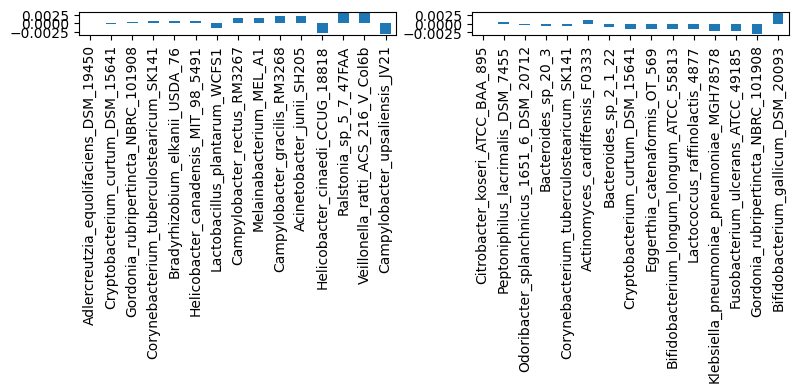

In [75]:
fig,ax = plt.subplots(1,2,figsize=(8,4))
PC.loc[PC[0].abs().sort_values().index][0].head(15).plot.bar(ax=ax[0])
PC.loc[PC[1].abs().sort_values().index][1].head(15).plot.bar(ax=ax[1])
# PC.loc[PC[2].abs().sort_values().index][2].head(15).plot.bar(ax=ax[2])
plt.tight_layout()

In [70]:
dct = {}
pos = pandas.concat([PC[PC>0],taxonomy],axis=1)
neg = pandas.concat([PC[PC<0],taxonomy],axis=1)
for pc in PC.columns:
    n = clean(neg.groupby("Genus").sum()[pc],cutoff=0.01)
    p = clean(pos.groupby("Genus").sum()[pc],cutoff=0.01)
    tmp = pandas.DataFrame()
    tmp["pos"] = p
    tmp["neg"] = n
    tmp = tmp.fillna(0.).sort_values("pos")
    dct[pc] = tmp

/tmp/ipykernel_3649262/2249196071.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  n = clean(neg.groupby("Genus").sum()[pc],cutoff=0.01)
/tmp/ipykernel_3649262/2249196071.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  p = clean(pos.groupby("Genus").sum()[pc],cutoff=0.01)
/tmp/ipykernel_3649262/2249196071.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  n = clean(neg.groupby("Genus").sum()[pc],cutoff=0.01)
/tmp

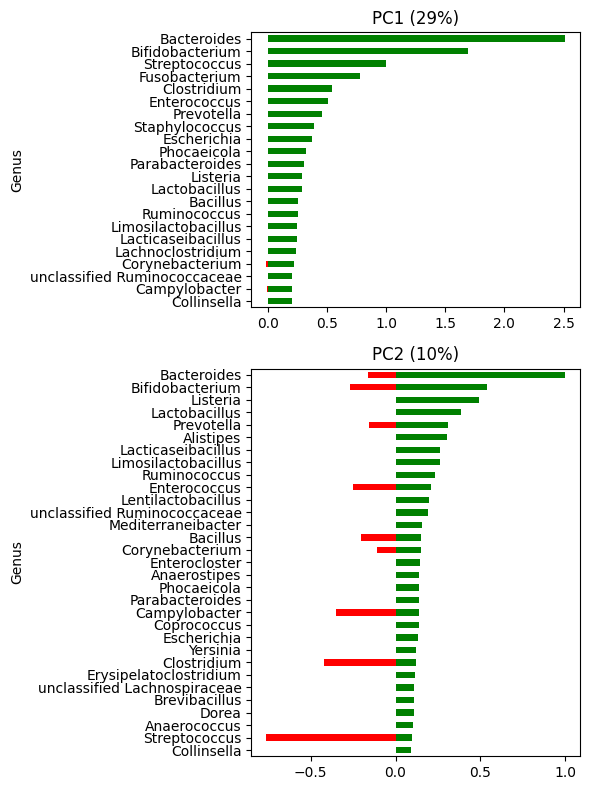

In [71]:
fig,ax = plt.subplots(2,1,figsize = (6,8),gridspec_kw={"height_ratios":[i.shape[0] for _,i in dct.items()]})
for pc,tmp in dct.items():
    ax[pc].set_title("PC{} ({}%)".format(pc+1,round(var[pc]*100)))
    tmp["pos"].plot.barh(ax=ax[pc],color="g")
    tmp["neg"].plot.barh(ax=ax[pc],color="r")
plt.tight_layout()
# plt.savefig("./figures/3.8.2.PCA-reaction-contributions.svg")

In [72]:
All = pandas.concat([PC,taxonomy],axis=1).dropna()
pc = 0
taxa = "Genus"
order = All.groupby(taxa).mean().sort_values(pc,ascending=False).index[::-1]
All[taxa] = pandas.Categorical(All[taxa], categories=order, ordered=True)

/tmp/ipykernel_3649262/1261564574.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  order = All.groupby(taxa).mean().sort_values(pc,ascending=False).index[::-1]


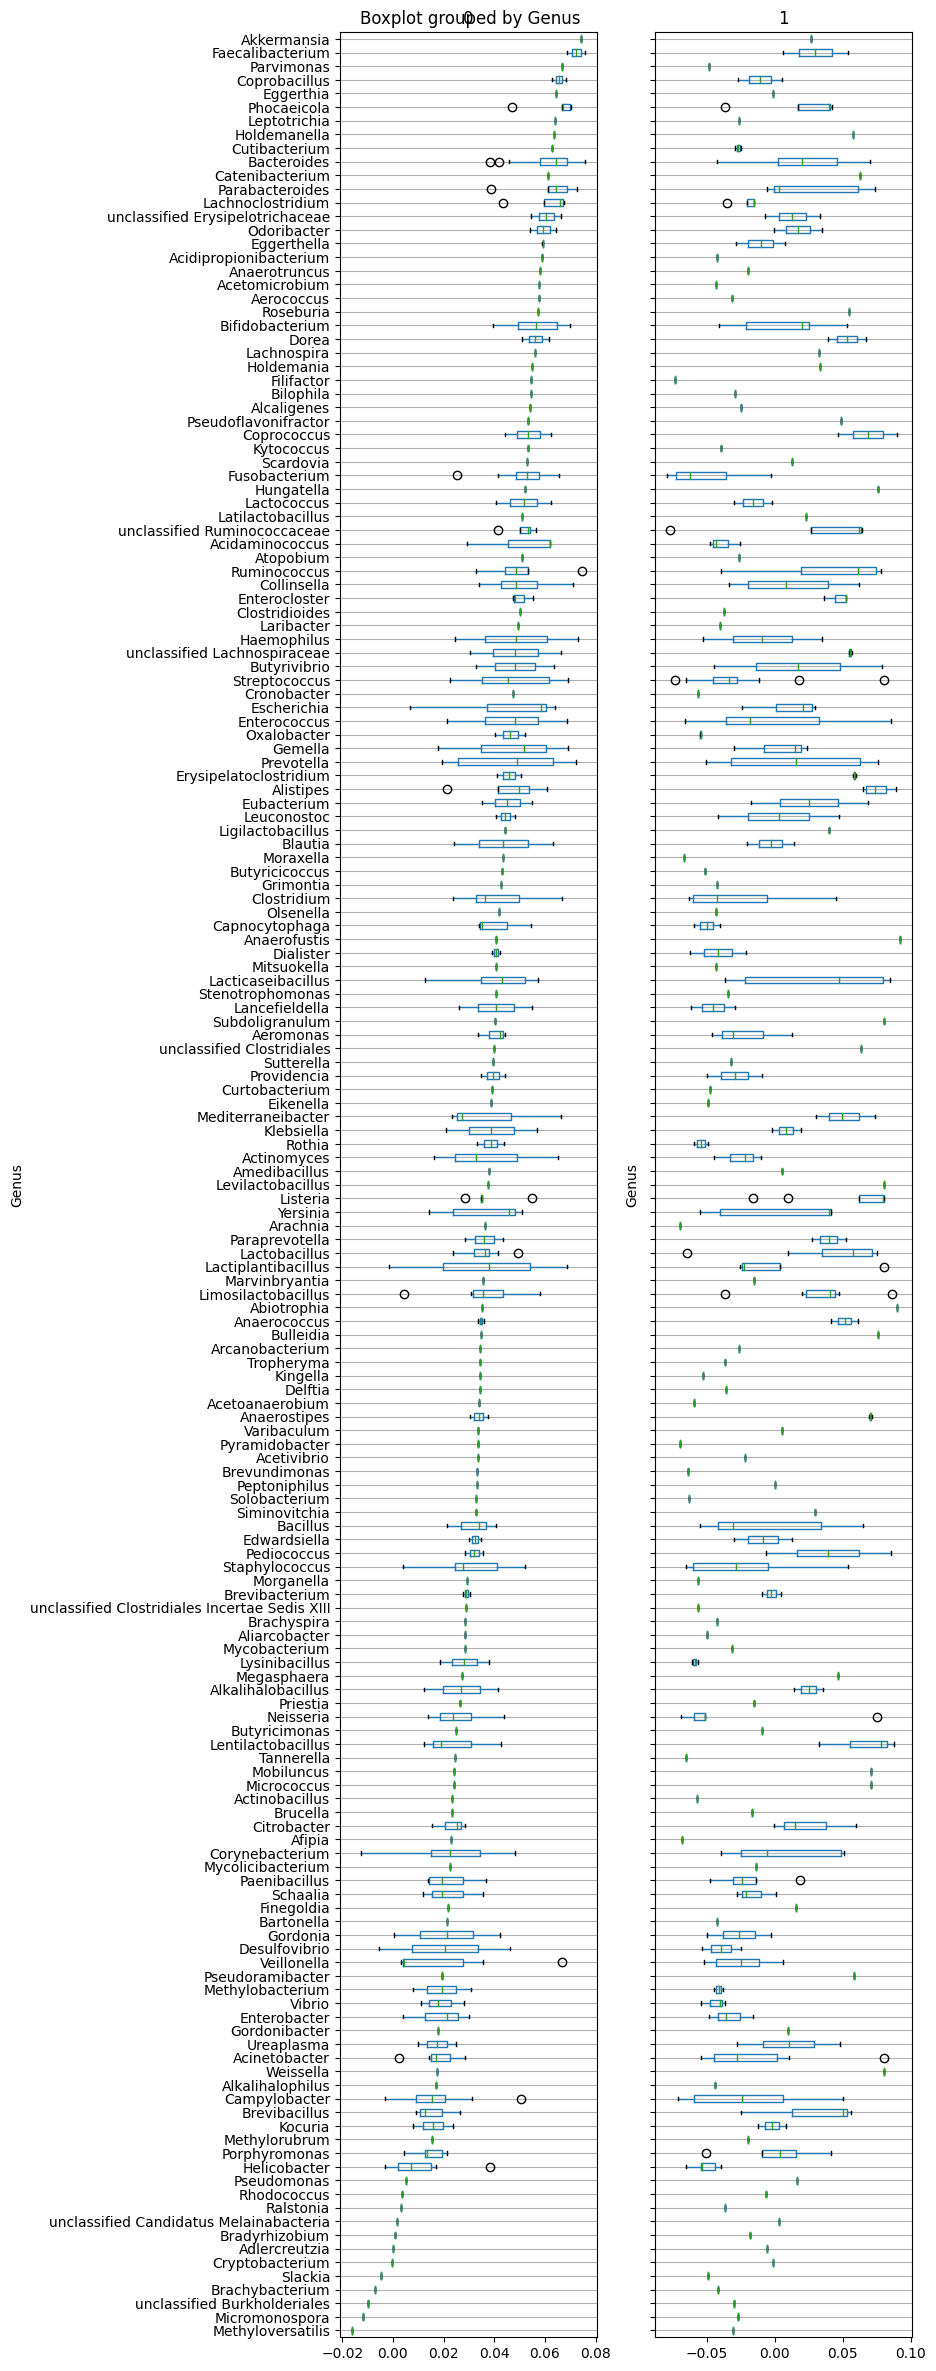

In [73]:
fig,ax = plt.subplots(1,2,figsize=(9.5,len(order)/7))
All.boxplot(0,by=taxa,vert=False,ax=ax[0])
All.boxplot(1,by=taxa,vert=False,ax=ax[1])
ax[0].grid(axis='x')
ax[1].grid(axis='x')
ax[1].set_yticklabels([])
fig.tight_layout()
# plt.savefig("./figures/3.8.2.PCA-reaction-contributions-groupedby{}.svg".format(taxa))

Text(0, 0.5, 'Principal Component 2')

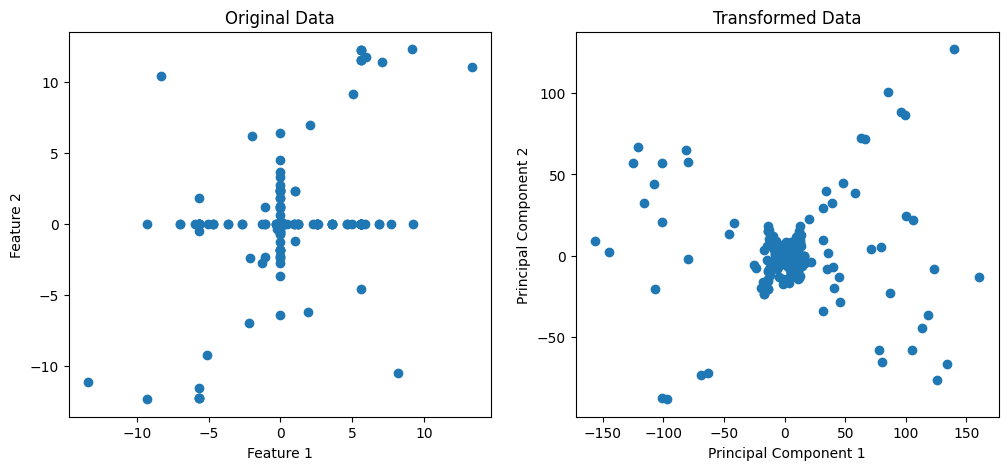

In [77]:
# Plot the original and transformed data
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot original data
ax[0].scatter(data[:, 0], data[:, 1], label='Original Data')
ax[0].set_title('Original Data')
ax[0].set_xlabel('Feature 1')
ax[0].set_ylabel('Feature 2')

# Plot transformed data
ax[1].scatter(data_pca[:, 0], data_pca[:, 1], label='Transformed Data')
ax[1].set_title('Transformed Data')
ax[1].set_xlabel('Principal Component 1')
ax[1].set_ylabel('Principal Component 2')

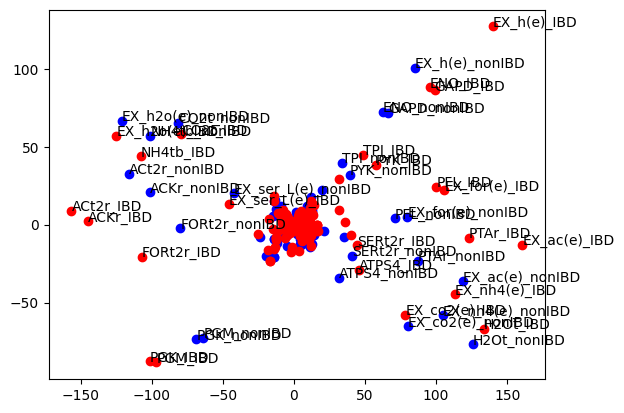

In [78]:
for idx,p in enumerate(data_pca):
    color = "b" if "nonIBD" in Data.index[idx] else "r"
    name = Data.index[idx]
    plt.plot(p[0],p[1],marker='o',color=color)
    if magnitude(p) > 2000:
        plt.text(p[0],p[1],name)
    # plt.text(p[0],p[1],name)

In [79]:
Positions = pandas.DataFrame(data_pca)
Positions.index = Data.index

Positions["OrganismName"] = [re.sub("_nonIBD$|_IBD$","",i) for i in Positions.index]
distances = {}
for i in Positions["OrganismName"].unique():
    try: 
        p1 = Positions.loc[i+"_nonIBD"][:2]
        p2 = Positions.loc[i+"_IBD"][:2]
    except:
        continue
    distances[i] = distance(p1,p2)


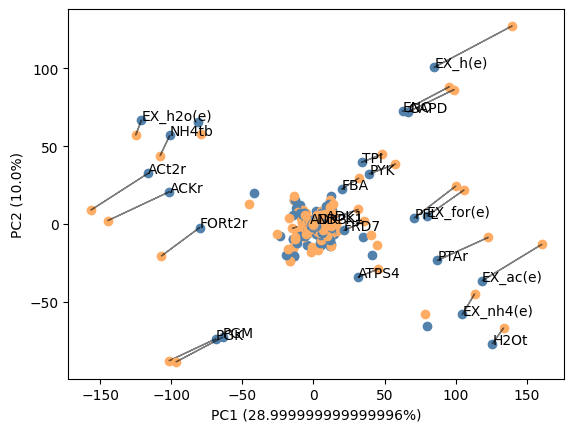

In [80]:
rlist = []
colors = ['#5282AC','#FFAD65']
tmp = Positions.set_index("OrganismName")
fig,ax = plt.subplots(1,1)
for o in tmp.index.unique():

    
    slice = tmp.loc[[o]]
    x1,y1 = slice.iloc[0,0],slice.iloc[0,1]
    x2,y2 = slice.iloc[1,0],slice.iloc[1,1]
    ax.scatter(x1,y1,color=colors[0])
    ax.scatter(x2,y2,color=colors[1])

    if distances.get(o,0) < 100:
        continue

    rlist.append(o)
    
    ax.arrow(x=x1,y=y1,dx=x2-x1,dy=y2-y1, head_width=0,alpha=0.5)
    ax.text(x1,y1,o)
    # break
ax.set_xlabel('PC1 ({}%)'.format(round(var[0],2)*100))
ax.set_ylabel('PC2 ({}%)'.format(round(var[1],2)*100))
plt.savefig("./figures/3.8.2.PCA-reaction.svg",format="SVG")

In [81]:
df = pandas.DataFrame.from_dict({"distance":distances})

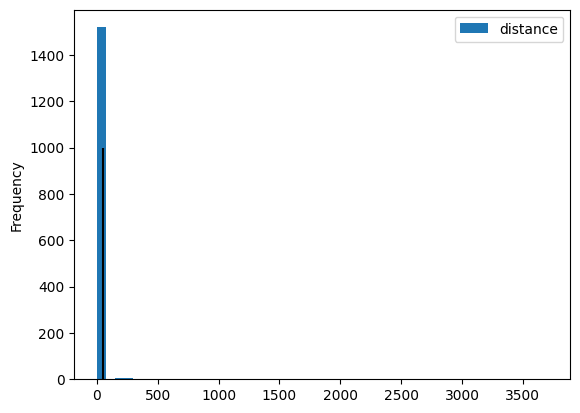

In [82]:
fig,ax = plt.subplots(1,1)
df.plot.hist(bins = 50,ax=ax)
ax.vlines(x=50,ymin=0,ymax=1000,color = "k")

#### Distance

In [83]:
from scipy.stats import pearsonr

In [84]:
distances = {}
for i in fluxes["nonIBD"].index:
    try: 
        p1 = fluxes["nonIBD"].loc[i].fillna(0.)
        p2 = fluxes["IBD"].loc[i].fillna(0.)
    except:
        continue

    p1[p1<1e-2] = 0
    p2[p2<1e-2] = 0
    # distances[i] = distance(p1,p2)
    distances[i] = pearsonr(p1,p2)[0]**2
    # distances[i] = pearsonr(p1,p2)[1]


/home/jt/venvs/coralme/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/jt/venvs/coralme/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/jt/venvs/coralme/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/jt/venvs/coralme/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/jt/venvs/coralme/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInput

/tmp/ipykernel_3649262/765275014.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby("subsystem").mean().sort_values("R2",ascending=True).head(30).iloc[::-1,:].plot.barh(ax=ax)


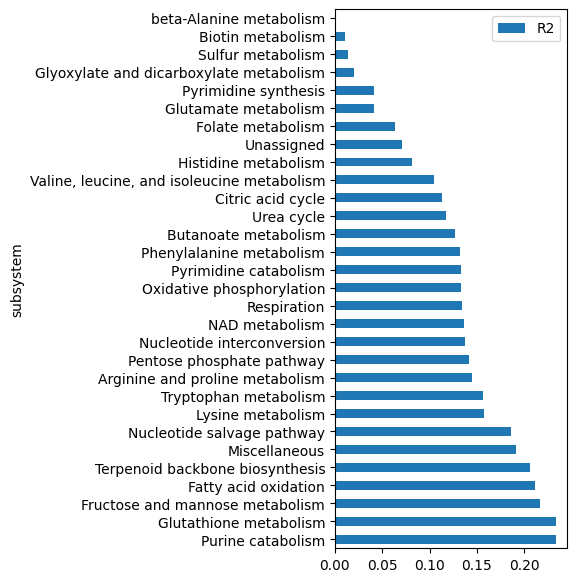

In [85]:
df = pandas.DataFrame.from_dict({"R2":distances})
df = pandas.concat([df,Annotation[Annotation["subsystem"]!="tRNA Charging"]],axis=1).dropna()

fig,ax = plt.subplots(1,1,figsize=(3,7))
df.groupby("subsystem").mean().sort_values("R2",ascending=True).head(30).iloc[::-1,:].plot.barh(ax=ax)
plt.savefig("./figures/3.8.2.TopSubsystemVariations.svg",format="SVG")

/tmp/ipykernel_3649262/1511357704.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby("subsystem").mean().plot.box()


<Axes: >

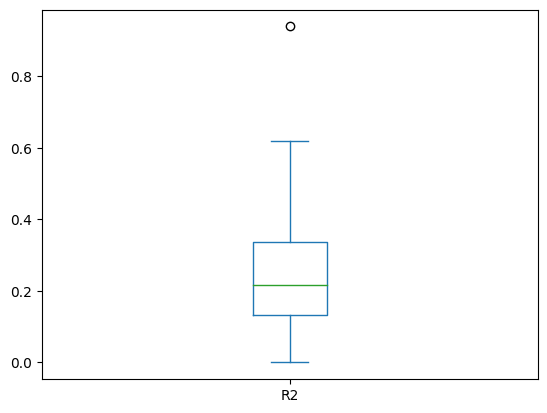

In [86]:
df.groupby("subsystem").mean().plot.box()

In [87]:
df[df["subsystem"] == "Phenylalanine metabolism"]

,R2,subsystem,name,reaction
CHORM,0.266282,Phenylalanine metabolism,chorismate mutase,chor_c --> pphn_c
CHORS,0.012726,Phenylalanine metabolism,chorismate synthase,3psme_c --> chor_c + pi_c
DDPA,0.012726,Phenylalanine metabolism,3-deoxy-D-arabino-heptulosonate 7-phosphate sy...,e4p_c + h2o_c + pep_c --> 2dda7p_c + pi_c
DHQS,0.012726,Phenylalanine metabolism,3-dehydroquinate synthase,2dda7p_c --> 3dhq_c + pi_c
DHQTi,0.012726,Phenylalanine metabolism,"3-dehydroquinate dehydratase, irreversible",3dhq_c --> 3dhsk_c + h2o_c
LARGNAT,0.099962,Phenylalanine metabolism,L-arogenate:2-oxoglutarate aminotransferase,Largn_c + oaa_c <=> asp__L_c + pphn_c
PHETA1,0.831764,Phenylalanine metabolism,Phenylalanine Transaminase,akg_c + phe__L_c <=> glu__L_c + phpyr_c
PPNDH,0.164104,Phenylalanine metabolism,prephenate dehydratase,h_c + pphn_c --> co2_c + h2o_c + phpyr_c
PSCVT,0.012726,Phenylalanine metabolism,3-phosphoshikimate 1-carboxyvinyltransferase,pep_c + skm5p_c <=> 3psme_c + pi_c
SHK3Dr,0.012726,Phenylalanine metabolism,shikimate dehydrogenase,3dhsk_c + h_c + nadph_c <=> nadp_c + skm_c


In [88]:
df[df["subsystem"] == "Sulfur metabolism"]

,R2,subsystem,name,reaction
SADT2,0.000004,Sulfur metabolism,Sulfate adenyltransferase,atp_c + gtp_c + h2o_c + so4_c --> aps_c + gdp_...
TRDRr,0.027712,Sulfur metabolism,Thioredoxin reductase (EC 1.8.1.9),h_c + nadph_c + trdox_c <=> nadp_c + trdrd_c


# PCA by microbe

In [89]:
from sklearn.decomposition import PCA
from scipy.stats import zscore

data1 = fluxes["nonIBD"].copy().fillna(0.)
data2 = fluxes["IBD"].copy().fillna(0.)

In [90]:
# # Get yields
# data1 = data1.div(growth["nonIBD"],axis=1)
# data2 = data2.div(growth["IBD"],axis=1)

In [91]:
data1.columns = [i+"_nonIBD" for i in data1.columns]
data2.columns = [i+"_IBD" for i in data2.columns]
Data = pandas.concat([data1,data2],axis=1).fillna(0.)

In [92]:
# Preprocessing
Data = Data[Data.any(axis=1)].T # All active 
# data = data.abs()
data = Data.apply(zscore,axis=1)
data.shape

(980, 1537)

In [93]:
pca = PCA(n_components = 2)
data_pca = pca.fit_transform(data)
var = pca.explained_variance_ratio_
components = pca.components_.T
var

array([0.18001179, 0.16364453])

In [94]:
PC= pandas.DataFrame(components)
PC.index = Data.columns

#### PC weights

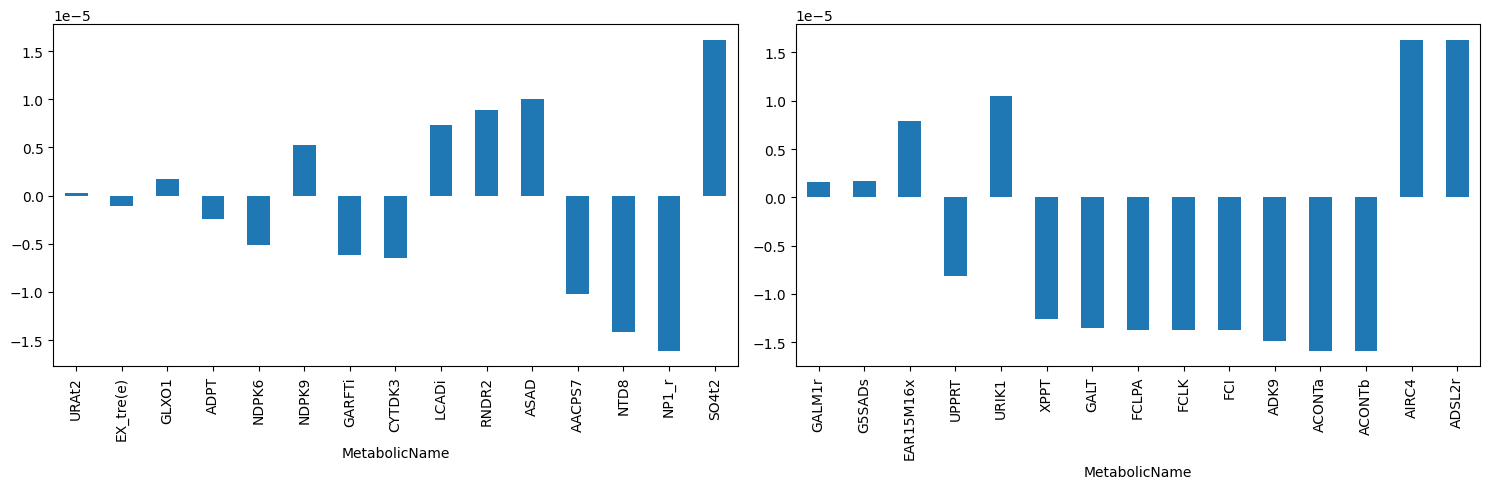

In [95]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
PC.loc[PC[0].abs().sort_values().index][0].head(15).plot.bar(ax=ax[0])
PC.loc[PC[1].abs().sort_values().index][1].head(15).plot.bar(ax=ax[1])
# PC.loc[PC[2].abs().sort_values().index][2].head(15).plot.bar(ax=ax[2])
plt.tight_layout()

#### PC weights

In [135]:
dct = {}
pos = pandas.concat([PC[PC>0],Annotation],axis=1)
neg = pandas.concat([PC[PC<0],Annotation],axis=1)
for pc in PC.columns:
    n = clean(neg.groupby("subsystem").mean()[pc])
    p = clean(pos.groupby("subsystem").mean()[pc])
    tmp = pandas.DataFrame()
    tmp["pos"] = p
    tmp["neg"] = n
    tmp = tmp.fillna(0.).sort_values("pos")
    dct[pc] = tmp

/tmp/ipykernel_3649262/2672430827.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  n = clean(neg.groupby("subsystem").mean()[pc])
/tmp/ipykernel_3649262/2672430827.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  p = clean(pos.groupby("subsystem").mean()[pc])
/tmp/ipykernel_3649262/2672430827.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  n = clean(neg.groupby("subsystem").mean()[pc])
/tmp/ipykernel_3649262

In [136]:
order = sorted(dct[0].index.to_list() + [i for i in dct[1].index if i not in dct[0].index],key=lambda x:x.upper())

In [137]:
for k,v in dct.items():
    v = v.T
    v[[i for i in order if i not in v.columns]] = 0
    dct[k] = v.T

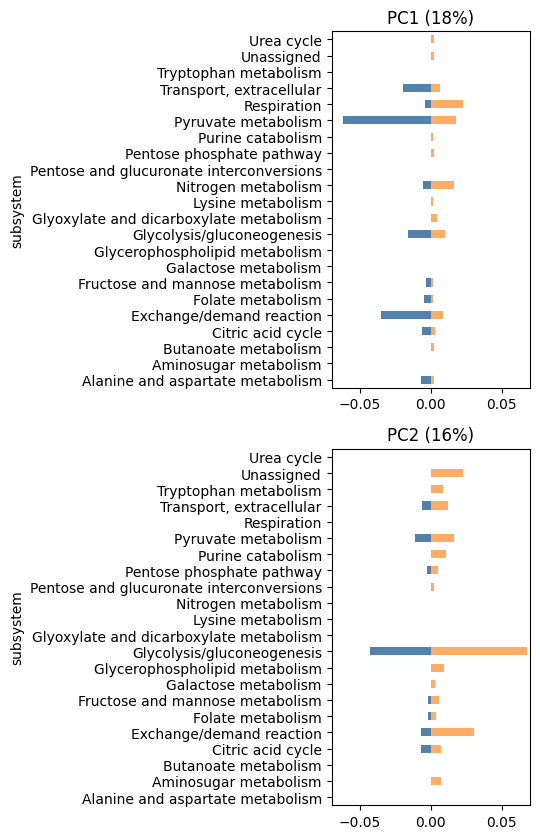

In [151]:
pos = pandas.concat([PC[PC>0],Annotation],axis=1)
neg = pandas.concat([PC[PC<0],Annotation],axis=1)
colors = ['#5282AC','#FFAD65']
fig,ax = plt.subplots(2,1,figsize = (5.5,8.5),gridspec_kw={"height_ratios":[i.shape[0] for _,i in dct.items()]})
for pc,tmp in dct.items():
    ax[pc].set_title("PC{} ({}%)".format(pc+1,round(var[pc]*100)))
    ax[pc].set_xlim([-0.07,0.07])
    tmp["pos"].loc[order].plot.barh(ax=ax[pc],color=colors[1])
    tmp["neg"].loc[order].plot.barh(ax=ax[pc],color=colors[0])
plt.tight_layout()
plt.savefig("./figures/3.8.2.PCA-by-microbe-reaction-contributions.svg",format="SVG")

#### Projection

Text(0, 0.5, 'PC2 (16.0%)')

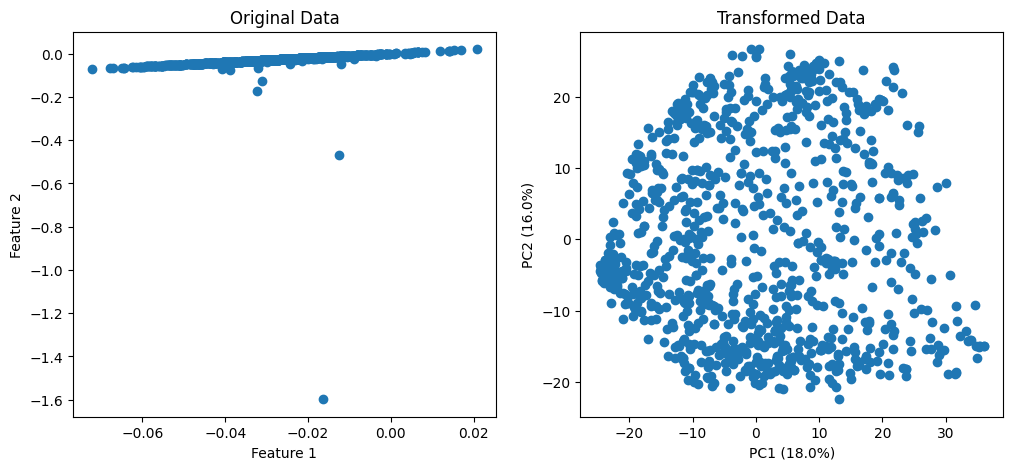

In [100]:
# Plot the original and transformed data
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot original data
ax[0].scatter(data.values[:, 0], data.values[:, 1], label='Original Data')
ax[0].set_title('Original Data')
ax[0].set_xlabel('Feature 1')
ax[0].set_ylabel('Feature 2')

# Plot transformed data
ax[1].scatter(data_pca[:, 0], data_pca[:, 1], label='Transformed Data')
ax[1].set_title('Transformed Data')
ax[1].set_xlabel('PC1 ({}%)'.format(round(var[0],2)*100))
ax[1].set_ylabel('PC2 ({}%)'.format(round(var[1],2)*100))

Text(0, 0.5, 'PC2 (16.0%)')

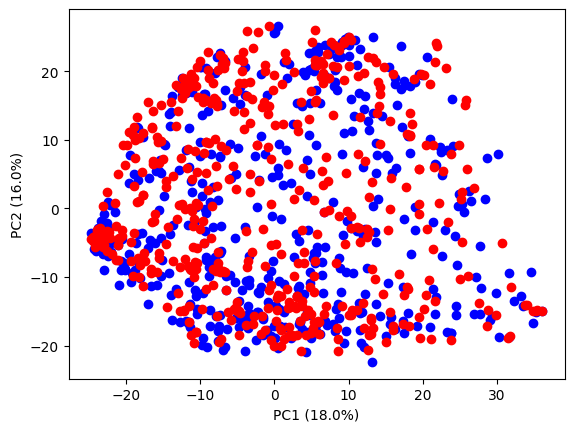

In [101]:
for idx,p in enumerate(data_pca):
    color = "b" if "nonIBD" in Data.index[idx] else "r"
    name = Data.index[idx]
    plt.plot(p[0],p[1],marker='o',color=color)
plt.xlabel('PC1 ({}%)'.format(round(var[0],2)*100))
plt.ylabel('PC2 ({}%)'.format(round(var[1],2)*100))
# plt.xlim([-5,20])

In [102]:
Positions = pandas.DataFrame(data_pca)
Positions.index = Data.index

Positions["OrganismName"] = [re.sub("_nonIBD$|_IBD$","",i) for i in Positions.index]
distances = {}
for i in Positions["OrganismName"].unique():
    try: 
        p1 = Positions.loc[i+"_nonIBD"][:2]
        p2 = Positions.loc[i+"_IBD"][:2]
    except:
        continue
    distances[i] = distance(p1,p2)


Text(0, 0.5, 'PC2 (16.0%)')

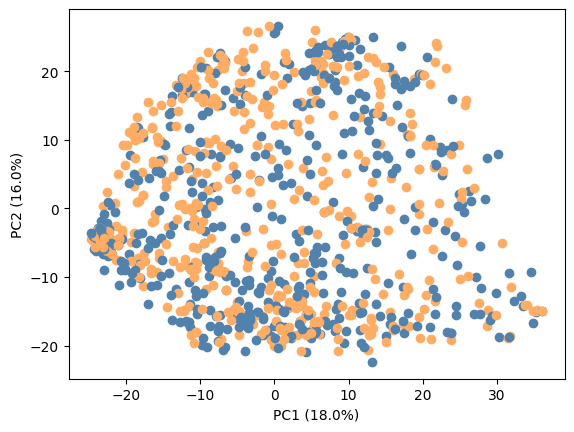

In [103]:
rlist = []
colors = ['#5282AC','#FFAD65']
tmp = Positions.set_index("OrganismName")
taxa = "Genus"
fig,ax = plt.subplots(1,1)
for o in tmp.index.unique():

    
    slice = tmp.loc[[o]]
    x1,y1 = slice.iloc[0,0],slice.iloc[0,1]
    x2,y2 = slice.iloc[1,0],slice.iloc[1,1]
    ax.scatter(x1,y1,color=colors[0])
    ax.scatter(x2,y2,color=colors[1])

    rlist.append(o)
    # break
ax.set_xlabel('PC1 ({}%)'.format(round(var[0],2)*100))
ax.set_ylabel('PC2 ({}%)'.format(round(var[1],2)*100))
# plt.savefig("./figures/3.8.2.PCA-reaction.svg",format="SVG")

Text(0, 0.5, 'PC2 (16.0%)')

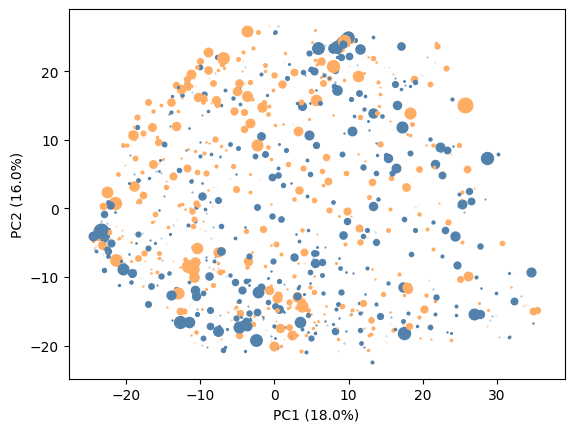

In [104]:
rlist = []
colors = ['#5282AC','#FFAD65']
tmp = Positions.set_index("OrganismName")
taxa = "Genus"
fig,ax = plt.subplots(1,1)
for o in tmp.index.unique():

    
    slice = tmp.loc[[o]]
    x1,y1 = slice.iloc[0,0],slice.iloc[0,1]
    x2,y2 = slice.iloc[1,0],slice.iloc[1,1]

    # if distances[o] <= 0:
    #     continue
    
    size = distances[o]/25
    
    ax.scatter(x1,y1,color=colors[0], s=size)
    ax.scatter(x2,y2,color=colors[1], s=size)
    
    rlist.append(o)
    # break

ax.set_xlabel('PC1 ({}%)'.format(round(var[0],2)*100))
ax.set_ylabel('PC2 ({}%)'.format(round(var[1],2)*100))
# plt.savefig("./figures/3.8.2.PCA-reaction.svg",format="SVG")

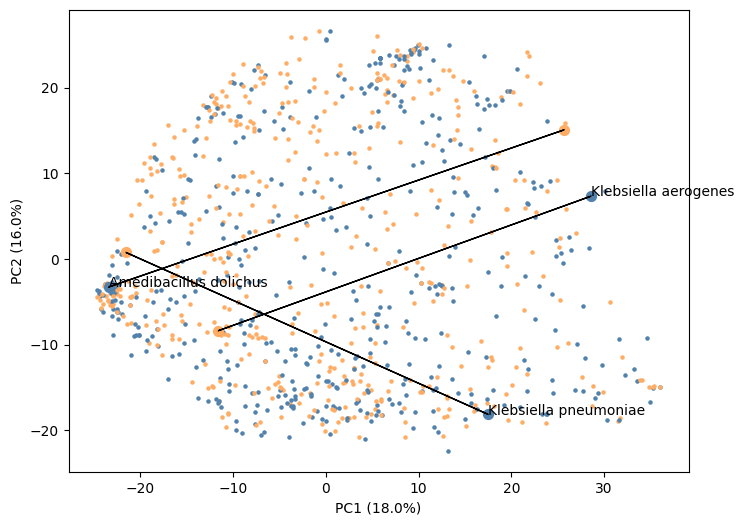

In [111]:
rlist = []
colors = ['#5282AC','#FFAD65']
tmp = Positions.set_index("OrganismName")
taxa = "Genus"
fig,ax = plt.subplots(1,1,figsize=(8,6))
for o in tmp.index.unique():

    
    slice = tmp.loc[[o]]
    x1,y1 = slice.iloc[0,0],slice.iloc[0,1]
    x2,y2 = slice.iloc[1,0],slice.iloc[1,1]
    ax.scatter(x1,y1,color=colors[0],s=5)
    ax.scatter(x2,y2,color=colors[1],s=5)

    if distances.get(o,0) < 1850:
        continue

    rlist.append(o)

for o in rlist:
    slice = tmp.loc[[o]]
    x1,y1 = slice.iloc[0,0],slice.iloc[0,1]
    x2,y2 = slice.iloc[1,0],slice.iloc[1,1]
    ax.scatter(x1,y1,color=colors[0],s=50)
    ax.scatter(x2,y2,color=colors[1],s=50)
    ax.arrow(x=x1,y=y1,dx=x2-x1,dy=y2-y1, head_width=0,alpha=1.0)
    # ax.text(x1,y1,taxonomy[taxa][o])
    ax.text(x1,y1,taxonomy["Species"][o])

ax.set_xlabel('PC1 ({}%)'.format(round(var[0],2)*100))
ax.set_ylabel('PC2 ({}%)'.format(round(var[1],2)*100))
plt.savefig("./figures/3.8.2.PCA-reaction-Highlighted.svg",format="SVG")

#### IBD and nonIBD separate

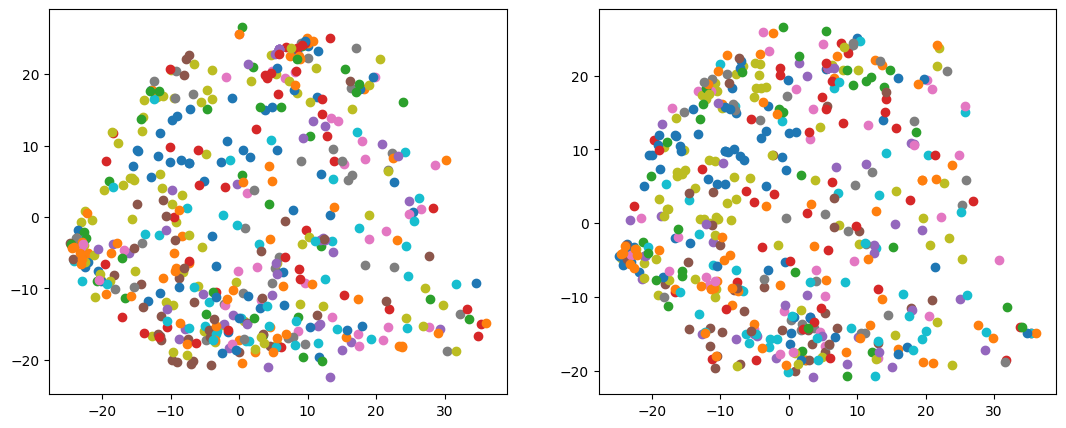

In [112]:
fig,ax = plt.subplots(1,2,figsize = (13,5))
tmp = Positions[Positions.index.str.contains("nonIBD")].set_index("OrganismName")
df = pandas.concat([tmp,taxonomy],axis=1).dropna()
taxa = "Genus"
groups = df.groupby(taxa)
for name, group in groups:
    ax[0].plot(group[0],group[1],linestyle='',marker="o")

tmp = Positions[~Positions.index.str.contains("nonIBD")].set_index("OrganismName")
df = pandas.concat([tmp,taxonomy],axis=1).dropna()
taxa = "Genus"
groups = df.groupby(taxa)
for name, group in groups:
    ax[1].plot(group[0],group[1],linestyle='',marker="o")

#### Distance

In [113]:
df = pandas.DataFrame.from_dict({"distance":distances})
df = pandas.concat([df,taxonomy],axis=1).dropna()

In [114]:
order = df.groupby(taxa).mean().sort_values("distance",ascending=False).index[::-1]
df[taxa] = pandas.Categorical(df[taxa], categories=order, ordered=True)

/tmp/ipykernel_3649262/1076356640.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  order = df.groupby(taxa).mean().sort_values("distance",ascending=False).index[::-1]


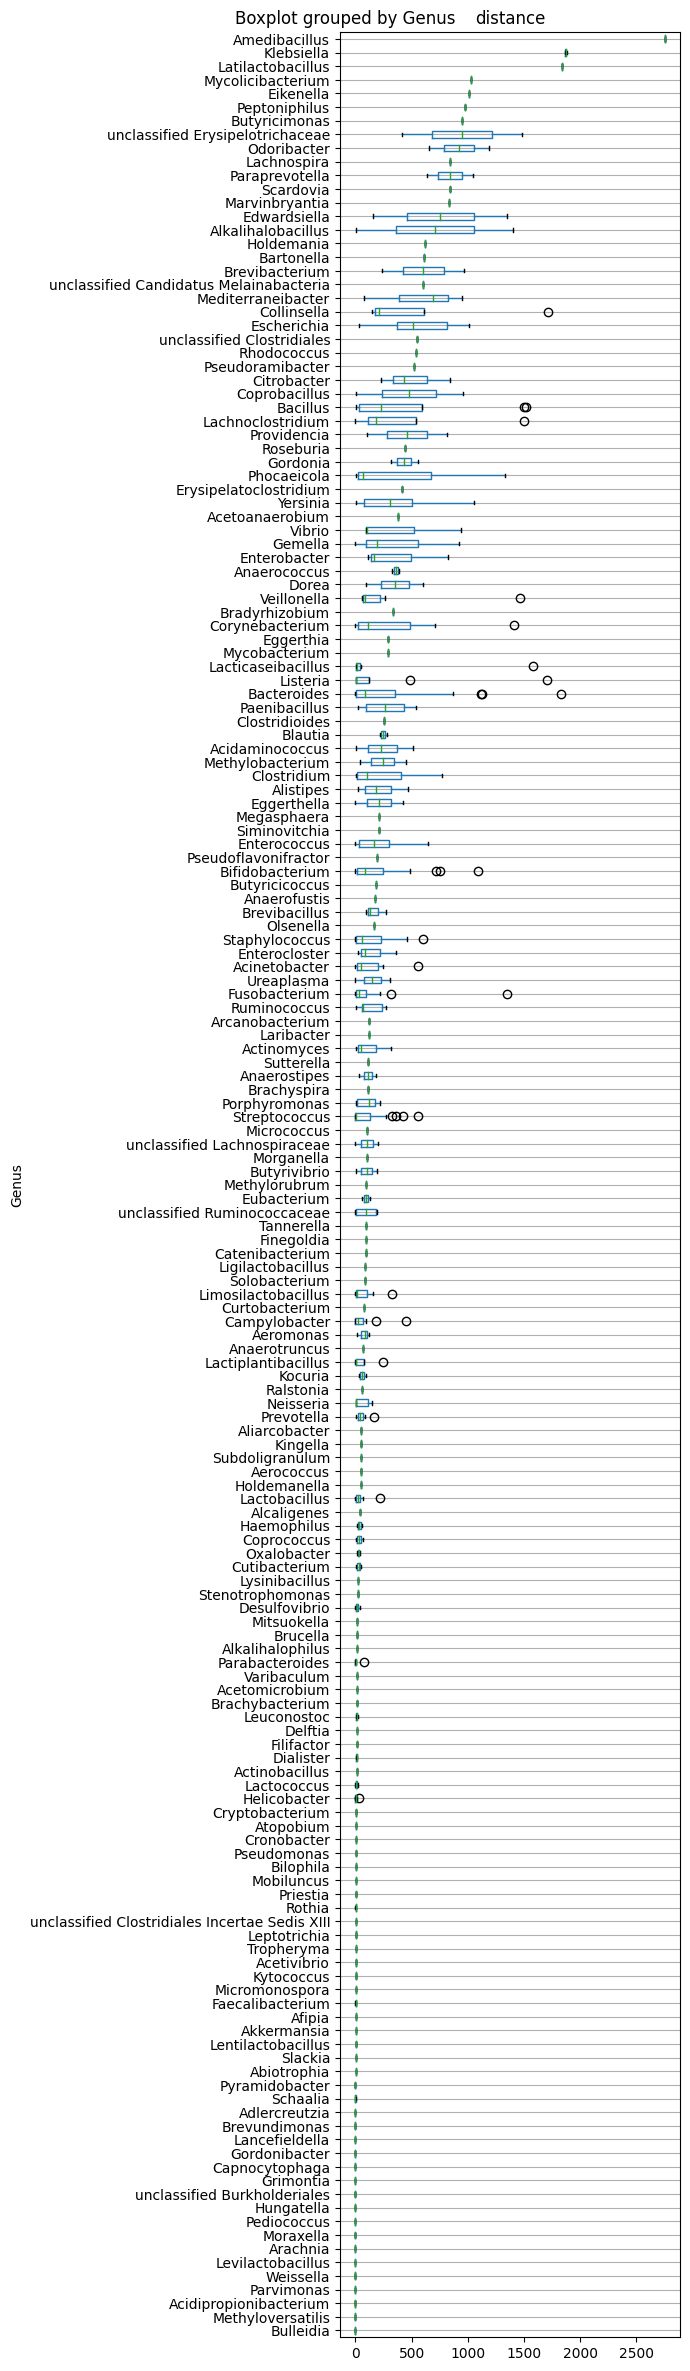

In [115]:
fig,ax = plt.subplots(1,1,figsize=(7,len(order)/7))
df.boxplot("distance",by=taxa,vert=False,ax=ax)
ax.grid(axis='x')
fig.tight_layout()

In [136]:
df = pandas.DataFrame.from_dict({"distance":distances})

<Axes: ylabel='Frequency'>

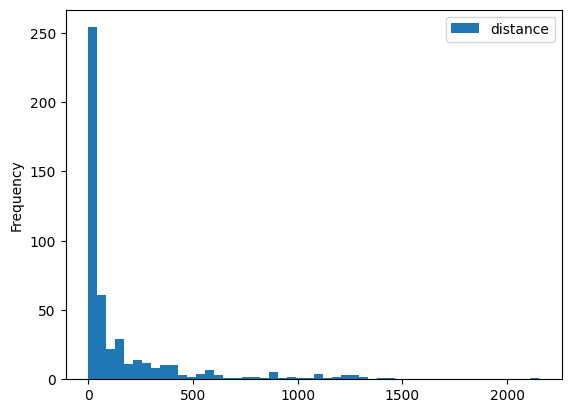

In [153]:
df.plot.hist(bins = 50)

<Axes: ylabel='Frequency'>

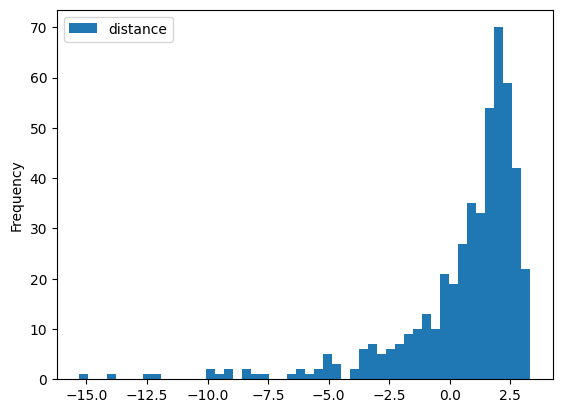

In [139]:
numpy.log10(df[df>0]).plot.hist(bins = 50)

# Correlation

In [158]:
from scipy.stats import pearsonr

In [159]:
dct = {}
for o in fluxes["nonIBD"].columns:
    x = fluxes["nonIBD"][o].fillna(0.)
    y = fluxes["IBD"][o].fillna(0.)
    dct[o] = {i:v for i,v in zip(["R","p"],pearsonr(x,y))}
Correlation = pandas.DataFrame.from_dict(dct).T
Correlation = pandas.concat([Correlation,taxonomy],axis=1).dropna()
Correlation["R2"] = Correlation["R"]**2

In [160]:
5/1.35

3.7037037037037033

/tmp/ipykernel_3649262/114638022.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  order = df.groupby(taxa).mean().sort_values("R2",ascending=False).iloc[::-1,:].index[::-1]


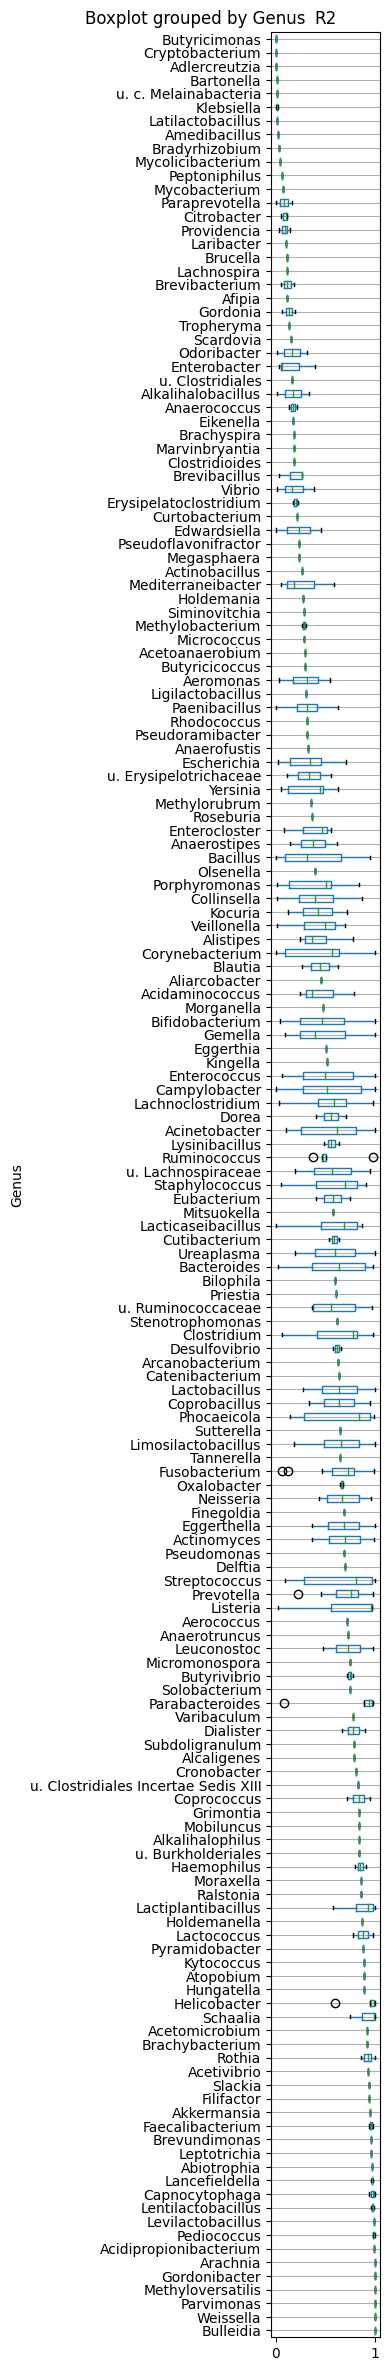

In [161]:
taxa = "Genus"
df = Correlation
df["Genus"] = df["Genus"].apply(lambda x:x.replace("unclassified","u.").replace("Candidatus","c."))
order = df.groupby(taxa).mean().sort_values("R2",ascending=False).iloc[::-1,:].index[::-1]
df[taxa] = pandas.Categorical(df[taxa], categories=order, ordered=True)
fig,ax = plt.subplots(1,1,figsize=(4,len(order)/7))
df.boxplot("R2",by=taxa,vert=False,ax=ax)
ax.grid(axis='x')
fig.tight_layout()
plt.savefig("./figures/3.8.2.PearsonCorrelationFluxes.svg",format="SVG")

In [162]:
df.groupby(taxa).mean().sort_values("R2",ascending=True).head(10)

/tmp/ipykernel_3649262/1436502211.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(taxa).mean().sort_values("R2",ascending=True).head(10)


,R,p,R2
Genus,,,
Butyricimonas,0.028991,2.550774e-01,0.000840
Cryptobacterium,0.031185,2.208522e-01,0.000972
Adlercreutzia,0.045760,7.233580e-02,0.002094
Bartonella,0.095241,1.792220e-04,0.009071
u. c. Melainabacteria,0.096155,1.550824e-04,0.009246
Klebsiella,0.089691,4.362973e-02,0.010174
Latilactobacillus,0.106308,2.859677e-05,0.011301
Amedibacillus,-0.159024,3.351178e-10,0.025289
Bradyrhizobium,0.186815,1.387266e-13,0.034900


In [178]:
df[df["Genus"] == "Enterobacter"][["R2"]].mean()

R2    0.162714
dtype: float64

#### Correlation of R2 and Diffs

In [124]:
import statsmodels.api as sm
from scipy import stats
SongbirdDifferentials = pandas.read_csv("./datasets/SongbirdDifferentials_CovParticipant.tsv",sep="\t",index_col=0,header=0)["numeric.1"]
Corr = pandas.DataFrame()
Corr["Diff"] = SongbirdDifferentials.abs()
Corr["R2"] = Correlation["R2"]
Corr = Corr.dropna()
X = Corr[["Diff"]].values
y = Corr[["R2"]].values

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     3.779
Date:                Thu, 18 Apr 2024   Prob (F-statistic):             0.0525
Time:                        09:31:55   Log-Likelihood:                -150.10
No. Observations:                 490   AIC:                             304.2
Df Residuals:                     488   BIC:                             312.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5198      0.021     24.275      0.0

In [180]:
# PCC
0.008**(0.5)

0.08944271909999159

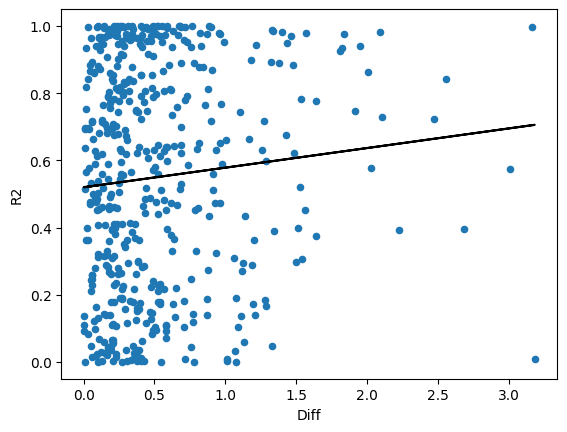

In [125]:
Corr.plot.scatter(x="Diff",y="R2")
plt.plot(Corr["Diff"],est2.predict(),color="black")
plt.savefig("./figures/3.8.2.Variation-Differentials-Correlation.svg",format="SVG")
